## Loading Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools as it
%matplotlib inline

## Investigating Activation Functions

### Sigmoid (Logistic) Function

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

$\sigma$ ranges from (0, 1). When the input $x$ is negative, $\sigma$ is close to 0. When $x$ is positive, $\sigma$ is close to 1. At $x=0$, $\sigma=0.5$

In [2]:
def show_me(xs, ys, ylim, cross):
    fig = plt.figure(figsize=(6,4))

    plt.grid(True, which='both')
    plt.axhline(y=0, color='y')
    plt.axvline(x=0, color='y')
    
    plt.plot(xs, ys)
    plt.plot(0,cross,'ro')

    plt.ylim(ylim)

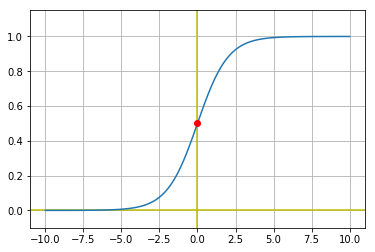

In [3]:
xs = np.linspace(-10.0, 10.0, num=100)
sigmoid = tf.nn.sigmoid(xs)
ys = tf.Session().run(sigmoid)
show_me(xs, ys, (-0.1, 1.15), .5)

Pros:

* Easy derivative
* Function looks like we think a neuron might function: it is either off or outputing a value (up to a maximum)

Cons: 

* Not symmetric, which causes issues when training
* Susceptible to vanishing gradients: when input values are saturated (either positively or negatively), the derivative is close to zero.

##### Derivative

Derivative of the sigmoid is easy to calculate if you know the output:

$$
\frac{d\sigma}{dx} = \sigma \left(1 - \sigma \right)
$$

### Hyperbolic Tangent (Tanh)

$$
tanh(x) = \frac{sinh(x)}{cosh(x)} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} = \frac{e^{2x} - 1}{e^{2x} + 1}
$$

Pros:
* Similar to sigmoid, but "stretched" to range from (-1, 1)
* Symmetric around 0, which helps for optimization

Cons:
* Still suffers from vanishing gradient

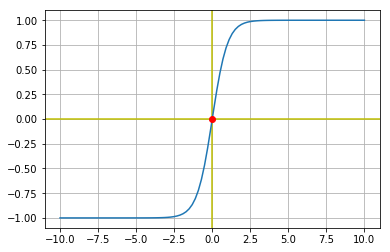

In [4]:
xs = np.linspace(-10.0, 10.0, num=100)
tanh = tf.nn.tanh(xs)
ys = tf.Session().run(tanh)
show_me(xs, ys, (-1.1, 1.1), 0.0)

##### Derivative

$$
\frac{dtanh}{dx} = 1 - tanh^{2} 
$$

### Rectified Linear Unit (ReLU)

$$
ReLU(x) = max\left(0,x\right) \\ \\
$$

Equivalent to:

$$
\begin{align*}
  ReLU(x) = \begin{cases}
    0 & \text{if $x\lt0$} \\
    x & \text{if $x\geq0$}
  \end{cases}
\end{align*}
$$

Pros:
* Incredibly easy to calculate output and derivative
* Doesn't suffer from vanishing gradient on positive side
* In practice tends to be more useful than sigmoid/tanh for typical activation functions

Cons:
* Not symmetric
* Can cause exploding activations if not careful
* Gradient can "die" if not careful

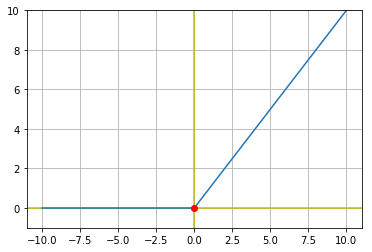

In [5]:
xs = np.linspace(-10.0, 10.0, num=100)
relu = tf.nn.relu(xs)
ys = tf.Session().run(relu)
show_me(xs, ys, (-1.0, 10.0), 0.0)

##### Derivative

$$
\begin{align*}
  \frac{dReLU}{dx} = \begin{cases}
    0 & \text{if $x\lt0$} \\
    1 & \text{if $x\geq0$}
  \end{cases}
\end{align*}
$$

### Leaky ReLU

$$
LReLU(x) = max\left(\alpha x,x\right) \\ \\
$$

Equivalent to:

$$
\begin{align*}
  ReLU(x) = \begin{cases}
    \alpha x & \text{if $x\lt0$} \\
    x & \text{if $x\geq0$}
  \end{cases}
\end{align*}
$$

Pros:
* Similar to ReLU, but doesn't "die".

Cons:
* Yet another hyper-parameter to tune.

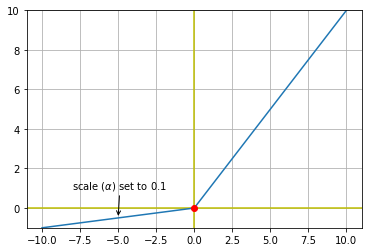

In [6]:
def leaky_relu(z, scale):
    return tf.maximum(tf.multiply(scale, z), z)
    
xs = np.linspace(-10.0, 10.0, num=100)
l_relu = leaky_relu(xs, 0.1)
ys = tf.Session().run(l_relu)
show_me(xs, ys, (-1.0, 10.0), 0.0)
plt.annotate(r'scale ($\alpha$) set to 0.1', 
             (-5, -.5), # where the arrow points to
             (-8, 1),   # where the text lives
             size=10, 
             arrowprops={'arrowstyle': '->'});

##### Derivative

$$
\begin{align*}
  \frac{dReLU}{dx} = \begin{cases}
    \alpha & \text{if $x\lt0$} \\
    1 & \text{if $x\geq0$}
  \end{cases}
\end{align*}
$$


## Shuffling and Batching

* We want to be able to randomly shuffle arrays in lock step (that is, apply the same permutation to several different arrays)
* We want a method that will gives us blocks (subsets) of a dataset

In [7]:
def shuffle(*args):
    "Shuffles list of NumPy arrays in unison"
    state = np.random.get_state()
    for array in args:
        np.random.set_state(state)
        np.random.shuffle(array)

def grouper(iter_, n):
    """Collect data into fixed-length chunks or blocks
     grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
     from python itertools docs"""
    args = [iter(iter_)] * n
    return zip(*args)

def batches(data, labels, batch_size, randomize=True):
    if len(data) != len(labels):
        raise ValueError('Image data and label data must be same size')
    if batch_size > len(data):
        raise ValueError('Batch size cannot be larger than size of datasets')
    if randomize: 
        shuffle(data, labels)
    for res in zip(grouper(data, batch_size),
                   grouper(labels, batch_size)):
        yield res

for b in batches(list(range(10)), 
                     list(range(100,110)), 
                     3, randomize=False):
    print(b)

((0, 1, 2), (100, 101, 102))
((3, 4, 5), (103, 104, 105))
((6, 7, 8), (106, 107, 108))


## Dropout

Dropout is included in TensorFlow in the form of [`tf.nn.dropout()`](https://www.tensorflow.org/api_docs/python/tf/nn/dropout). You simply pass a `Tensor` and a desired keep probability (usually from a placeholder) into it, and it returns a `Tensor` that will have values randomly dropped at a rate of $p = 1 - keep\_prob$.  TF automatically performs the scaling necessary to keep the expected value of the outputs consistent.

An interesting feature of this scaling is that it actually takes the opposite approach of what is described in the dropout academic paper. Instead of scaling the values of a neuron down _after_ training, it scales them up _during_ training. Let's take a look at the scaling so we can see what's going on under the hood.

In [8]:
a = np.ones(10)
dropper = tf.nn.dropout(a, keep_prob=0.5) # named arg for clarity
tf.Session().run(dropper)

array([0., 0., 2., 0., 0., 2., 2., 2., 2., 0.])

With a `keep_prob` of 0.5, the expected value of the inputs _without_ dropout is `2*a`. That's why we see the input values of 1 multiplied by 2.

## Creating layers with custom layer functions

Let's take a look at these three example layers:

```python
with tf.name_scope('hidden1'):
    w = tf.Variable(tf.truncated_normal([100, 300]), name='W')
    b = tf.Variable(tf.zeros([300]), name='b')
    z = tf.matmul(x, w) + b
    a = tf.nn.sigmoid(z)
 
with tf.name_scope('hidden2'):
    w = tf.Variable(tf.truncated_normal([300, 300]), name='W')
    b = tf.Variable(tf.zeros([300]), name='b')
    z = tf.matmul(x, w) + b
    a = tf.nn.sigmoid(z)
    
with tf.name_scope('output'):
    w = tf.Variable(tf.truncated_normal([300, 50]), name='W')
    b = tf.Variable(tf.zeros([50]), name='b')
    z = tf.matmul(a, w) + b
```

### Fully Connected Layers

Looking at the above, we can start breaking down the patterns we see:

* We always have weight and bias Variables, `w`, and `b`
* The first dimension of the weight variable should be the previous layer's depth
* The depth of the layer can be any scalar
* The output layer doesn't have an activation function
* We'd like to group everything with a name scope.

Additionally, there are some other features that we'd like to look out for:

* Optionally use dropout
* Want to be able to use any activation function we want
* Want to be able to set the `w` standard deviation and `b` starting number

Here's an example layer that achieves this:

In [9]:
def fully_connected_layer(incoming_layer, num_nodes, activation_fn=tf.nn.sigmoid,
                          w_stddev=0.5, b_val=0.0, keep_prob=None, name=None):
    
    incoming_layer = tf.convert_to_tensor(incoming_layer)
    prev_num_nodes = incoming_layer.shape.dims[-1].value
    
    with tf.name_scope(name, 'fully_connected'):
        tn = tf.truncated_normal([prev_num_nodes, num_nodes], 
                                 stddev=w_stddev)
        W = tf.Variable(tn, name='W')
        const = tf.constant(b_val, shape=[num_nodes])
        b = tf.Variable(const, name='bias')
        
        z = tf.matmul(incoming_layer, W) + b
        
        a = activation_fn(z) if activation_fn is not None else z 
        final_a = a if keep_prob is None else tf.nn.dropout(a, keep_prob)
        
        return final_a

In [10]:
x = tf.placeholder(tf.float32, shape=[None,20], name="x")

h1 = fully_connected_layer(x, 40, name='h1')
h2 = fully_connected_layer(h1, 20, keep_prob=.8, name='h2')

# fully connected from h2 to me (out)
out = fully_connected_layer(h2, 10, name='out')

print(h1)
print(h2)
print(out)

Tensor("h1/Sigmoid:0", shape=(?, 40), dtype=float32)
Tensor("h2/dropout/mul:0", shape=(?, 20), dtype=float32)
Tensor("out/Sigmoid:0", shape=(?, 10), dtype=float32)


Tensor's have a [`TensorShape`](https://www.tensorflow.org/api_docs/python/tf/TensorShape) attribute that stores their size.  We use `incoming_layer.shape.dims[-1].value` to get the ouput size of the prior layer as a Python scalar.

Here's how to replicate the previous code:

    fc = fully_connected_layer(x, 300,  name='hidden1')
    fc = fully_connected_layer(fc, 300, name='hidden2')
    z  = fully_connected_layer(fc, 50, activation_fn=None, name='output')

### Flattening Layers

The code below is another commonly used type of layer. It "flattens" a tensor (excluding the first dimension, which is the number of batches). For example, a matrix of ten 28x28 RGB images normally has a shape like this: `[10, 28, 28, 3]`. However, our model expects inputs to only be dimension 2. By flattening it, we "string out" the input pixels into a vector of length `28*28*3=2352`, so our final output shape is `[10, 2352]`

In [11]:
def flatten(incoming, name=None):
    flat_shape = [-1, np.prod(incoming.shape[1:]).value]
    return tf.reshape(incoming, flat_shape)

In [12]:
x = tf.placeholder(tf.uint8, shape=[None, 28, 28, 3], name="x")
flatten(x)

<tf.Tensor 'Reshape:0' shape=(?, 2352) dtype=uint8>

## The MNIST Dataset

##### Download and Open MNIST data

Data was downloaded from 'https://web.archive.org/web/20160828233817/' and saved as numpy arrays,

In [13]:
mnist_numpy_paths = {'train_data'  : 'data/mnist-train-images.npy',
                     'train_labels': 'data/mnist-train-labels.npy',
                     'test_data'   : 'data/mnist-test-images.npy',
                     'test_labels' : 'data/mnist-test-labels.npy'}

train_data = np.load(mnist_numpy_paths['train_data'])
train_labels = np.load(mnist_numpy_paths['train_labels'])
test_data = np.load(mnist_numpy_paths['test_data'])
test_labels = np.load(mnist_numpy_paths['test_labels'])

In [14]:
print(train_data.shape,
      train_data[0].shape, sep='\n')

(60000, 28, 28, 1)
(28, 28, 1)


Here's a quick look at what our primitive data looks like (literally):

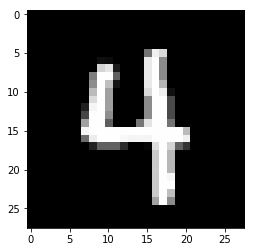

In [15]:
def show_image(img):
    imgplot = plt.imshow(np.squeeze(img), cmap='Greys_r')

pick_me = np.random.randint(len(test_data))
show_image(test_data[pick_me])

Let's create a model that can recognize these images.  We're going to make use of `batches`, `flatten`, and `fully_connected_layer` from above.  
Note that implementations which yield a higher accuracy are possible by changing, e.g., the learning rate, the activation functions, the optimizer, etc. Here, we are mostly concerned with 'stitching' together the various part of a model.

In [16]:
class MNIST_Model(object):
    def __init__(s):  # non-standard, for abbreviation
        graph = tf.Graph()
        with graph.as_default():
            
            with tf.name_scope('inputs'):
                s.x = tf.placeholder(tf.uint8, shape=[None, 28, 28, 1], name="x")
                s.y = tf.placeholder(tf.int32, shape=[None])

            with tf.name_scope('hyperparams'):
                s.learning_rate = tf.placeholder(tf.float32, [], 'learning_rate')
                s.momentum      = tf.placeholder(tf.float32, [], 'momentum')
   
                s.x_keep_prob = tf.placeholder(tf.float32, [], 'x_keep_prob')
                s.h_keep_prob = tf.placeholder(tf.float32, [], 'h_keep_prob')
            
            with tf.name_scope('preprocess'):
                x_flat  = flatten(s.x)
                x_float = tf.cast(x_flat, tf.float32) 
                s.x_dropped = tf.nn.dropout(x_float, s.x_keep_prob)
                s.one_hot_labels = tf.one_hot(s.y, 10)

            with tf.name_scope('model'):
                make_fc = fully_connected_layer # abbreviation
                
                s.h1  = make_fc(s.x_dropped, 1200, activation_fn=tf.nn.sigmoid, w_stddev=0.01,
                                b_val=0.1, keep_prob=s.h_keep_prob, name='h1')                
                s.h2  = make_fc(s.h1, 1200, activation_fn=tf.nn.sigmoid, w_stddev=0.01,
                                b_val=0.1, keep_prob=s.h_keep_prob, name='h2')
                s.h3  = make_fc(s.h2, 1200, activation_fn=tf.nn.sigmoid, w_stddev=0.01,
                                b_val=0.1, keep_prob=s.h_keep_prob, name='h3')

                s.out = make_fc(s.h3, 10, activation_fn=None, name='out') 
            
            with tf.name_scope('loss'):
                smce = tf.nn.softmax_cross_entropy_with_logits_v2
                s.loss = tf.reduce_mean(smce(logits=s.out, labels=s.one_hot_labels))

            with tf.name_scope('train'):
                # using a momentum optimizer to (hopefully) make faster
                # progress in regions where we'd prefer to take bigger steps
                opt = tf.train.MomentumOptimizer(s.learning_rate, s.momentum)
                #opt = tf.train.RMSPropOptimizer(s.learning_rate)
                s.train = opt.minimize(s.loss)

            with tf.name_scope('global_step'):
                global_step = tf.Variable(0, trainable=False, name='global_step')
                s.inc_step = tf.assign_add(global_step, 1, name='inc_step')
            
            with tf.name_scope('prediction'):
                s.softmax = tf.nn.softmax(s.out, name="softmax")
                s.prediction = tf.cast(tf.argmax(s.softmax, 1), tf.int32)
                s.pred_correct = tf.equal(s.y, s.prediction)
                s.pred_accuracy = tf.reduce_mean(tf.cast(s.pred_correct, tf.float32)) 
                
            s.init = tf.global_variables_initializer()
            
        s.session = tf.Session(graph=graph)
        s.session.run(s.init)
    
    def fit(s, train_dict):
        tr_loss, step, tr_acc, _ = s.session.run([s.loss, s.inc_step, s.pred_accuracy, 
                                                  s.train], feed_dict=train_dict)
        return tr_loss, step, tr_acc
    
    def predict(s, test_dict):
        ct_correct, preds = s.session.run([s.pred_correct, s.prediction], 
                                          feed_dict=test_dict)
        return ct_correct, preds

In [17]:
mm = MNIST_Model()
for epoch in range(10):
    for batch_data, batch_labels in batches(train_data, train_labels, 100):
        m = min(.5 + epoch * 0.001, 0.99) # safeguard for very large # epochs
        train_dict = {mm.x : batch_data, 
                      mm.y : batch_labels, 

                      mm.learning_rate : 0.01,
                      mm.momentum      : m,

                      mm.x_keep_prob : 0.8,
                      mm.h_keep_prob : 0.5}
        tr_loss, step, tr_acc = mm.fit(train_dict)
    info_update = "Epoch: {:2d} Step: {:5d} Loss: {:8.2f} Acc: {:5.2f}"
    print(info_update.format(epoch, step, tr_loss, tr_acc))

Epoch:  0 Step:   600 Loss:     1.07 Acc:  0.66
Epoch:  1 Step:  1200 Loss:     0.55 Acc:  0.83
Epoch:  2 Step:  1800 Loss:     0.57 Acc:  0.83
Epoch:  3 Step:  2400 Loss:     0.44 Acc:  0.88
Epoch:  4 Step:  3000 Loss:     0.43 Acc:  0.86
Epoch:  5 Step:  3600 Loss:     0.46 Acc:  0.82
Epoch:  6 Step:  4200 Loss:     0.25 Acc:  0.90
Epoch:  7 Step:  4800 Loss:     0.34 Acc:  0.93
Epoch:  8 Step:  5400 Loss:     0.20 Acc:  0.94
Epoch:  9 Step:  6000 Loss:     0.26 Acc:  0.89


In [18]:
# Get test accuracy
batch_correct_cts = []
for batch_data, batch_labels in batches(test_data, test_labels, 200):
    test_dict = {mm.x : batch_data,   mm.x_keep_prob : 1.0,
                 mm.y : batch_labels, mm.h_keep_prob : 1.0}
    correctness, curr_preds = mm.predict(test_dict)
    batch_correct_cts.append(correctness.sum())

print(sum(batch_correct_cts) / len(test_data))

0.9458


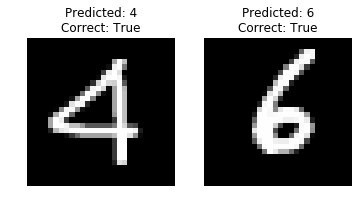

In [19]:
def test_and_show_images(data, labels):
    test_dict = {mm.x : data,   mm.x_keep_prob : 1.0,
                 mm.y : labels, mm.h_keep_prob : 1.0}
    
    correctness, curr_preds = mm.predict(test_dict)
    
    # setup axes
    fig, axes = plt.subplots(nrows=(len(data) // 3) + 1, ncols=3, figsize=(9,len(data)*1.5))
    axes = axes.flat
    for d, lbl, c, p, ax in zip(data, labels, correctness, curr_preds, axes):
        ax.imshow(np.squeeze(d), cmap='Greys_r') # FIXME: is cmap needed?
        ax.set_title("Predicted: {}\nCorrect: {}".format(p, bool(c)))
        ax.axis('off')
    for ax in axes: ax.set_visible(False)

indices = [25, 125]
test_and_show_images(test_data[indices], test_labels[indices])

In [20]:
# Get correct and incorrect images
correctness = []
for batch_data, batch_labels in batches(test_data, test_labels, 200):
    test_dict = {mm.x : batch_data,   mm.x_keep_prob : 1.0,
                 mm.y : batch_labels, mm.h_keep_prob : 1.0}
    curr_correctness, curr_preds = mm.predict(test_dict)
    correctness.extend(curr_correctness)

incorrect = np.where(np.logical_not(np.array(correctness, dtype=np.bool)))[0]

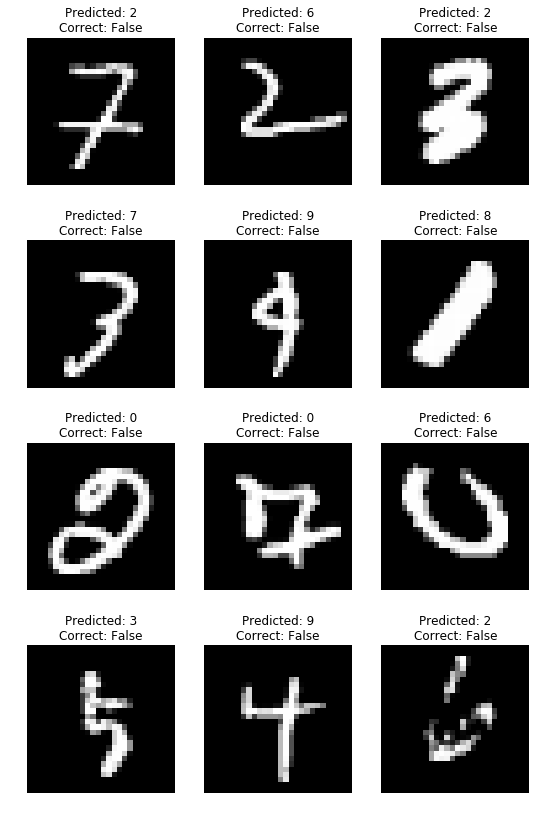

In [21]:
# viewing some incorrect images
indices = incorrect[:12]
test_and_show_images(test_data[indices], test_labels[indices])